<a href="https://colab.research.google.com/github/bork0047/Data-Analysis/blob/main/ANN_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import our libraries

In [ ]:
import pandas as pd # to manage data frames and reading csv files
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
np.random.seed(42) 

# 0. Preliminaries

## Set our Global Variables
later you will need to modify these to present your solution to the Exercise

In [ ]:
#number of input, hidden and output nodes
input_nodes = 784 #we have a 28x28 matrix to describe each digit
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.3
batch_size = 1 # increase this if you want batch gradient descent

# epochs is the number of training iterations 
epochs = 10

# datasets to read
# you can change these when trying out other datasets
train_file = "sample_data/mnist_train_small.csv"
test_file = "sample_data/mnist_test.csv"

### Get the MNIST Data into a ataframe

In [ ]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

y_train_all =  pd.get_dummies(df_orig_train[0]).values # this is the class column
X_train_all = df_orig_train.drop(0, axis = 1).values # maintain all columns after dropping the class column
print(y_train_all.shape)
print(X_train_all.shape)

y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 119.8 MB
(20000, 10)
(20000, 784)
(10000, 10)
(10000, 784)


## <font color='red'>Exercises</font> with the MNIST dataset
Print the contents of the dataframes to understand how the instances and the output target values are stored. You can use head() and tail() functions on any data frame.

## Helper functions to preprocess the data
MNIST is a large dataset and sometimes it helps to work with a small sample before running it on the full data. 
These helper functions allow you to control that by setting the train_sample_size.

In [ ]:
# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 2000  # choosing a smaller sample instead of the entire dataset
print("Percentage of training data used: ", train_sample_size/len(y_train_all) * 100)
test_sample_size = 2000 # len(y_test_all)
print("Percentage of testing data used: ", test_sample_size/len(y_test_all) * 100)

Percentage of training data used:  10.0
Percentage of testing data used:  20.0


In [ ]:
# get indices for random sampling
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)

# get a smaller random sample
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)

#preprocessing steps to normalise the mnist data
X_train = (X_train / 255.0 * 0.99) + 0.01 # scale and shift the inputs
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)

# do the same steps now for the test data
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)

X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)

(2000, 10)
(2000, 784)
(2000, 10)
(2000, 784)


## Helper functions for evaluation
The MSE is a measure of the quality of an estimator—it is always non-negative, and values closer to zero are better.
see for instance a detailed discussion [here](https://en.wikipedia.org/wiki/Mean_squared_error).

Accuracy is another metric for evaluating classification models. Informally, accuracy is the fraction of predictions our model got right. 

If you want to find out more about different types of metrics there is an overview [here](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e382340). 

In [ ]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy


### Helper classes for activations

In [ ]:
class Activation_ReLU:
    def forward(self, x):
        return(np.maximum(0, x))
    def backward(self, x):
        return(np.greater(x, 0).astype(int)) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

## Class Definitions



In [ ]:
class Optimizer_SGD:
    def __init__(self, learningrate=0.3):
           self.lr = learningrate
            
    def weight_update(self, layer):       
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases


In [ ]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # weights initialised from a gaussian with mean 0 and variance 1
        # multiply with a small value just to ensure we start with small weight values
        self.weights = 0.1*  np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs, act):
        self.inputs = inputs #need this when backpropagating so maintain it in the layer class
        z = np.dot(inputs , self.weights) + self.biases # weights dot product
        self.outputs = act.forward(z) # nonlinear activation output of the layer
            
    def backward(self, error, act):
        delta = error * act.backward(self.outputs)
        self.dinputs = np.dot(delta, self.weights.T)  #this layer's error 
        
        N = self.dinputs.shape[0]
        self.dweights = np.dot(self.inputs.T, delta) / N  # derivatives for weights used by the optimizer class  
        self.dbiases = np.mean(delta, axis=0, keepdims=True) # derivatives for biases used by the optimizer class 


### Creating Layers
#### <font color='red'>Exercises</font> Complete the code to include batching during training


In [ ]:
# SOLUTION from last week improved
np.random.seed(42)
layer1 = Layer_Dense(784, 300) 
layer2 = Layer_Dense(300, 64) 
layer3 = Layer_Dense(64, 10) 

act1 = Activation_ReLU()
act2 = Activation_ReLU()
act3 = Activation_Sigmoid()
learning_rate = 0.3

opt  = Optimizer_SGD(learning_rate)

# maintain a dataframe to keep track of the network error
monitoring = {}
monitoring['mean_squared_error'] = []
monitoring['accuracy'] = []

# Variable to hold the batch size
batch_size = 10 #len(X_train)
# iterate and update weights at each epoch
for epoch in range(20):
  for i in range(0, len(X_train), batch_size):
    
    X_train_batch= X_train[i:i + batch_size]
    y_train_batch= y_train[i:i + batch_size]
    layer1.forward(X_train_batch, act1)   
    layer2.forward(layer1.outputs, act2)
    layer3.forward(layer2.outputs, act3)

    #calculate the loss
    loss=(layer3.outputs - y_train_batch)

    # backprop through the layers
    layer3.backward(loss, act3)
    layer2.backward(layer3.dinputs, act2)
    layer1.backward(layer2.dinputs, act1)

    # update all the layer weights
    opt.weight_update(layer3)
    opt.weight_update(layer2)
    opt.weight_update(layer1)
  #end of batching loop for training

  # Get predictions on the traiing data
  layer1.forward(X_train, act1)   
  layer2.forward(layer1.outputs, act2)
  layer3.forward(layer2.outputs, act3)
  pred = layer3.outputs
  mse = mean_squared_error(pred, y_train)
  acc = accuracy(pred, y_train)
  monitoring['mean_squared_error'].append(mse)
  monitoring['accuracy'].append(acc)
  #end of epoch for loop

monitoring_df = pd.DataFrame(monitoring)   
monitoring_df

,mean_squared_error,accuracy
0,0.043519,0.1110
1,0.043397,0.1110
2,0.043289,0.1110
3,0.043136,0.1280
4,0.042304,0.2135
5,0.036261,0.3360
6,0.030675,0.4965
7,0.023065,0.6450
8,0.017235,0.7690
9,0.013757,0.8055


# 1.0 Build our Artificial Neural Network class

## <font color='red'>Exercises</font> Complete the ANN class methods

In [ ]:
class ANN():
    def __init__(self, ouput_layer, act2, hidden_layer, act1, opt, batch_size = 10):
        self.layer2 = ouput_layer
        self.act2 = act2
        self.layer1 = hidden_layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size

    # Write a method to return consecutive batches from x and y 
    # with each batch being of the size specified by self.batch_size
    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])
            
    # alternate implmentation without yield is less optimised
    #def batch_input_v2(self, x, y):
        #batches = []
        #for i in range(0, len(x), self.batch_size):
          #batch_x = x[i:i + self.batch_size]
          #batch_y = y[i:i + self.batch_size]
          #batches.append((batch_x, batch_y))
        #return (batches)

    def train(self, x, y, epochs, opt, lr=0.3):
        opt.lr = lr


        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):
            
            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)

                #calculate the loss
                loss=(self.layer2.outputs-batch_y)
                
                # backprop through the layers 
                self.layer2.backward(loss, self.act2)
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2)
               
            # check models prediction capability
            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        return self.layer2.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

## <font color='red'>Exercises</font> Using Artificial Neural Net Class to train a model

To train an ANN; first configure the layers and use them to initialise the ANN object. 
Use the train method to train the model based on the hyperparameters being set. 

Complete the code below. 

In [ ]:
np.random.seed(42)

# set other hyperparameters
batch_size = 20
epochs = 10
lr = 0.3
act1 = Activation_ReLU()
act2 = Activation_Sigmoid()
sgd = Optimizer_SGD()

# configure the layers
hidden = Layer_Dense(784,64)
output = Layer_Dense(64,10)

# create an ANN model
ann = ANN(output, act2, hidden, act1, sgd, batch_size)

# train the ANN model with training data
train_performance = ann.train(X_train, y_train, epochs, sgd, lr)

train_performance

,mean_squared_error,accuracy
0,0.043474,0.1115
1,0.033712,0.4670
2,0.023760,0.6845
3,0.018491,0.7745
4,0.014806,0.8525
5,0.011753,0.8880
6,0.009893,0.9040
7,0.008707,0.9125
8,0.007862,0.9160
9,0.007202,0.9230


### Plot the model error and accuracy with increasing epochs

Error at the end of each epoch has been stored in self.E
We can now use mathplotlib to plot the error at the end of each epoch. 
Our expectation is that as we continue to descend (hill-walking) we should move closer to the minima
as such error should decrease. 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
train_performance.mean_squared_error.plot(ax=axes[0], title="Mean Squared Error", xlabel = "epochs")
print(train_performance)

train_performance.accuracy.plot(ax=axes[1], title="Accuracy", xlabel = "epochs") 
#plt.savefig('train_performance.png', dpi=300) # uncomment to save this plot



# 2.0 Exploring different values of a hyperparameter - a comparative study on the batch_size

In [ ]:
print("This will take a few moments ...")
ann_list = []
train_results_list = []
batch_sizes = [1, 20, 100, 200, 500, len(X_train)]
lr=0.3
epochs=10
act1 = Activation_ReLU()
act2 = Activation_Sigmoid()
sgd = Optimizer_SGD()

for batch_size in batch_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size) # create a new ANN model with a specific batch size
    
    train_performance=ann.train(X_train, y_train, epochs, sgd, lr) # train the model

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list

print('completed')

This will take a few moments ...
completed


## Gather the test results for each ANN

In [ ]:
#iterate through each model and accumulate number of correct predictions


test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

Mean Squared Error and Accuracy Results 
 [(0.006336155601908827, 0.9235), (0.0092389890404743, 0.8855), (0.032535101529176, 0.5135), (0.043131244947902665, 0.2865), (0.04402670943451509, 0.1675), (0.04684975219556329, 0.0955)]


#### Create a convenient dataframe to hold all the test results

In [ ]:
print(test_results_list)


df_batch_results = pd.DataFrame(test_results_list, columns=['mean_squared_error','accuracy' ], index=batch_sizes)
df_batch_results.head()

[(0.006336155601908827, 0.9235), (0.0092389890404743, 0.8855), (0.032535101529176, 0.5135), (0.043131244947902665, 0.2865), (0.04402670943451509, 0.1675), (0.04684975219556329, 0.0955)]


,mean_squared_error,accuracy
1,0.006336,0.9235
20,0.009239,0.8855
100,0.032535,0.5135
200,0.043131,0.2865
500,0.044027,0.1675


## Create a bar chart to analyse the mean squared error and accuracy results

[(0.006336155601908827, 0.9235), (0.0092389890404743, 0.8855), (0.032535101529176, 0.5135), (0.043131244947902665, 0.2865), (0.04402670943451509, 0.1675), (0.04684975219556329, 0.0955)]


Text(0.5, 1.0, 'Accuracy')

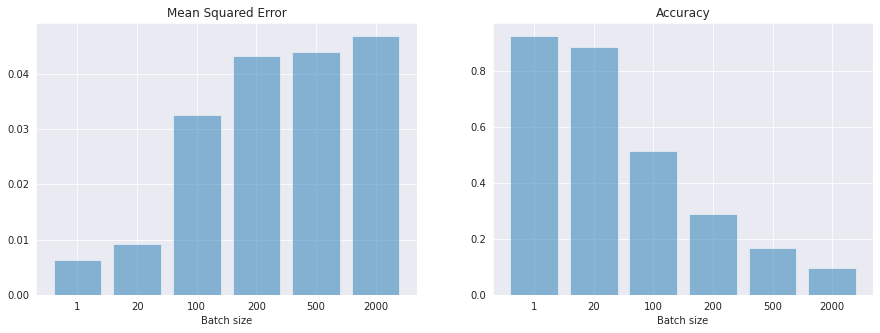

In [ ]:
objects = batch_sizes
performance = test_results_list
print(performance)
# plot performances bars
fig, axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(objects))
# get mean squared error from performance
model_mse = [x[0] for x in performance]
axes[0].bar(y_pos, model_mse, align='center', alpha=0.5)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Batch size')
axes[0].set_title('Mean Squared Error')

# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes[1].bar(y_pos, model_acc, align='center', alpha=0.5)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Batch size')
axes[1].set_title('Accuracy')


## Study the impact of varying two hyper parameters on the ANN

In [ ]:
# Try different configurations of hidden layer and batch size
print("Percentage of training data used: ", (len(y_train)/len(y_train_all)) * 100)

print("This will take a few moments ...")
train_results_list = []
ann_list = []
batch_sizes = [1, 20, 100, 200, 500, len(y_train)]  # lets try six different configurations of batch sizes
hidden_nodes = [200, 5]  # two different configurations of hidden node layer
epochs=20
lr=0.3
sgd = Optimizer_SGD()

# lets create the set of modesl
for hidden in hidden_nodes:
    ann_list_element = [] # first set of nets with a given hidden node size
    for batch in batch_sizes:
        # configure the layers
        hidden_layer = Layer_Dense(784, hidden)
        output_layer = Layer_Dense(hidden, 10)
        
        ann_ = ANN(output_layer, act2, hidden_layer, act1, sgd, batch) # create a new ANN model with a specific batch size

        train_performance = ann_.train(X_train, y_train, epochs, sgd, lr) # train the model

        train_results_list.append(train_performance)
        ann_list_element.append(ann_) # maintain each ANN model in a list
 
        pass
    
    ann_list.append(ann_list_element)# now append the set of models 
    pass

#lets test the models 
model_results = []
model_result_element = []

for model1 in ann_list:
    model_result_element = []
    
    for model2 in model1:
        df_test_result = model2.test(X_test, y_test)
        mse=df_test_result['mean_squared_error'].values
        acc=df_test_result['accuracy'].values

        model_result_element.append((mse[0], acc[0]))
        pass
    model_results.append(model_result_element)
    pass

print('completed')

Percentage of training data used:  10.0
This will take a few moments ...
completed


## Plot the results of hidden nodes versus batch size

In the graph below we have plotted the accuracy for 6 different batch sizes comparing against 2 architectures (one with 200 hidden nodes and the other with 4 hidden nodes). 
As expected when the ANN architecture has fewer hidden nodes it has less opportunity to learn a sensible mapping between the input features and expected outputs.

Text(0.5, 1.0, 'Mean Squared Error Average')

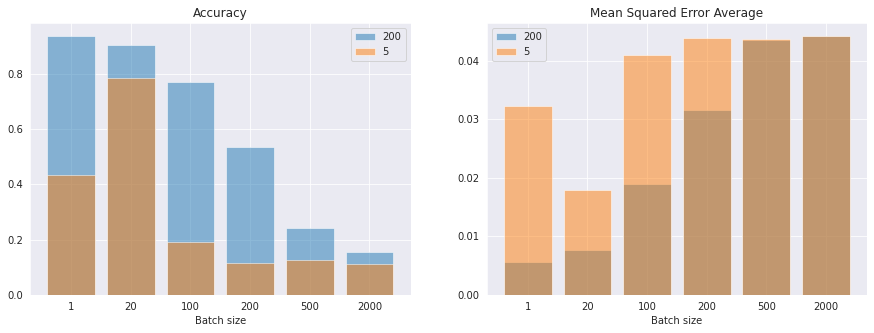

In [ ]:
objects = batch_sizes

fig, axes = plt.subplots(1, 2, figsize=(15,5))

for result in model_results:
    performance_mse = [x[0] for x in result]  # mean squared error
    performance_acc = [x[1] for x in result]  # accuracy
    axes[0].bar(y_pos, performance_acc, align='center', alpha=0.5 )  # add accuracy to plot
    axes[1].bar(y_pos, performance_mse, align='center', alpha=0.5 )  #  add mean squared error to plot

y_pos = np.arange(len(objects))
axes[0].legend(hidden_nodes)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Batch size')
axes[0].set_title('Accuracy')

axes[1].legend(hidden_nodes)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Batch size')
axes[1].set_title('Mean Squared Error Average')

## Exercises loosly aligned to CW1

How would you interpret the results from the graph above?

You should now try exploring with different hyper-parameters: 

- What is the effect of increasing learning rate on accuracy?
- What happens to network error with increased number of epochs?
- What is the effect of increasing training epochs on test set accuracy?
- What happens to accuracy when you increase batch size?
- Explore the different charting functionality provided by matplotlib (https://matplotlib.org/)

Try to examine the ANN class closely:
- Can you understand how the gradients are used to tweak the weights so as to move towards a local minima of reducing error?
- You might want to write a helper function to compare the hidden_inputs values and the hidden_outputs after the activation function is applied in the query function.
- Pay attention to the training time when you use the entire MNIST train instances versus a smaller sample such as 1500.


### Advanced

- What is the effect of increasing the nummber of hidden layer nodes on accuracy?
Hint: You need to modify the ANN class methods init, train and prediction.
- In the lecture we covered the sigmoid activation function and in this code we have implemented both the forward function and the derivatives in the backward function (see activation class). How might you change the code to use the ReLu activation function instead of the sigmoid?

## <font color='red'>Exercises</font> Advanced

- Modify the code above to add a further hidden layer? Your first layer must match the 784 feature dimension of the instance and your last layer must output 10 signals to align with the 10 MNIST class digits. But the middle layers can have any reasonable dimension. Ensure that between layers the dimension sizes match.
- Increase or decrease the epochs?
- What combination of epochs and layers help acheive the highest accuracy (or lowest error)?

In [ ]:
# class modified to add an exrta hidden_layer2
class ANN():
    def __init__(self, ouput_layer, act3, hidden_layer2, act2, hidden_layer1, act1, opt, batch_size = 10):
        self.layer3 = ouput_layer
        self.act3 = act3
        self.layer2 = hidden_layer2
        self.act2 = act2              # new hidden layer's activation
        self.layer1 = hidden_layer1   # new hidden layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, opt, lr=0.3):
        opt.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)
                self.layer3.forward(self.layer2.outputs, self.act3)

                #calculate the loss
                loss=(self.layer3.outputs-batch_y)
                
                # backprop through the layers 
                self.layer3.backward(loss, self.act3) # change to add the new layer               
                self.layer2.backward(self.layer3.dinputs, self.act2) # change to add the new layer      
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2) # change to add the new layer      
                self.opt.weight_update(self.layer3)               

            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        self.layer3.forward(self.layer2.outputs, self.act3) # change to add the new layer  
        return self.layer3.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

In [ ]:
np.random.seed(42)

# set other hyperparameters
batch_size = 20
epochs = 10
lr = 0.3
act1 = Activation_ReLU()
act2 = Activation_ReLU()
act3 = Activation_Sigmoid()
sgd = Optimizer_SGD()

# configure the layers
hidden1 = Layer_Dense(784,128) # change to add the new layer  
hidden2 = Layer_Dense(128,32) # change to add the new layer  
output = Layer_Dense(32,10)

# create an ANN model
ann = ANN(output, act3, hidden2, act2, hidden1, act1, sgd, batch_size)

# train the ANN model with training data
train_performance = ann.train(X_train, y_train, epochs, sgd, lr)

train_performance

,mean_squared_error,accuracy
0,0.043545,0.1110
1,0.043459,0.1110
2,0.043401,0.1110
3,0.043351,0.1110
4,0.043304,0.1145
5,0.043255,0.1195
6,0.043194,0.1355
7,0.043099,0.1675
8,0.042856,0.2075
9,0.040777,0.2135


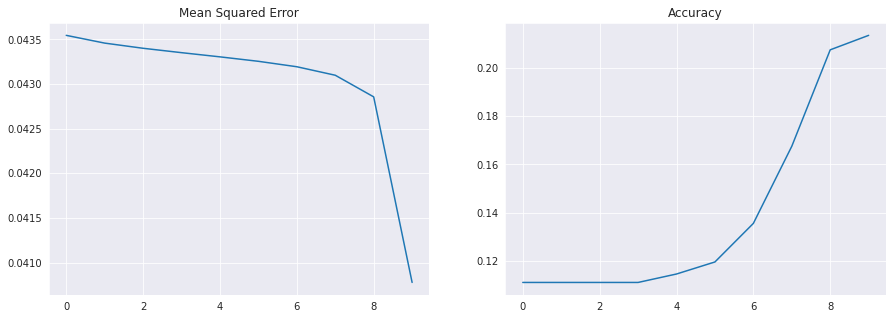

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
train_performance.mean_squared_error.plot(ax=axes[0], title="Mean Squared Error")

train_performance.accuracy.plot(ax=axes[1], title="Accuracy") 
#plt.savefig('train_performance.png', dpi=300) # uncomment to save this plot

In [ ]:
print('X_test.shape => {} '.format(X_test.shape))
print('y_test.shape => {} '.format(y_test.shape))
test_performance = ann.test(X_test, y_test)
test_performance

X_test.shape => (2000, 784) 
y_test.shape => (2000, 10) 


,mean_squared_error,accuracy
0,0.041037,0.208


In [ ]:
print("This will take a few moments ...")
ann_list = []
train_results_list = []
batch_sizes = [1, 20, 100, 200, 500, len(X_train)]
lr=0.7
epochs=20
act1 = Activation_ReLU()
act2 = Activation_ReLU()
act3 = Activation_Sigmoid()
sgd = Optimizer_SGD()

for batch_size in batch_sizes:
    # configure the layers
    hidden1 = Layer_Dense(784,128) # change to add the new layer  
    hidden2 = Layer_Dense(128,32) # change to add the new layer  
    output = Layer_Dense(32,10)

    # create an ANN model
    ann = ANN(output, act3, hidden2, act2, hidden1, act1, sgd, batch_size)

    # train the ANN model with training data
    train_performance = ann.train(X_train, y_train, epochs, sgd, lr)

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list

print('completed')

This will take a few moments ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


completed


In [ ]:
#iteratre through each model and accumilate number of correct predictions


test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

Mean Squared Error and Accuracy Results 
 [(0.12715598948670787, 0.1135), (0.007150325707124278, 0.9035), (0.04259960198936965, 0.2035), (0.043347698075996956, 0.1275), (0.043426061461807774, 0.14), (0.04987145491538856, 0.0975)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


In [ ]:
print(test_results_list)
df_batch_results = pd.DataFrame(test_results_list, columns=['mean_squared_error', 'accuracy'], index=batch_sizes)
df_batch_results.head()

[(0.12715598948670787, 0.1135), (0.007150325707124278, 0.9035), (0.04259960198936965, 0.2035), (0.043347698075996956, 0.1275), (0.043426061461807774, 0.14), (0.04987145491538856, 0.0975)]


,mean_squared_error,accuracy
1,0.127156,0.1135
20,0.007150,0.9035
100,0.042600,0.2035
200,0.043348,0.1275
500,0.043426,0.1400


Text(0.5, 1.0, 'Accuracy')

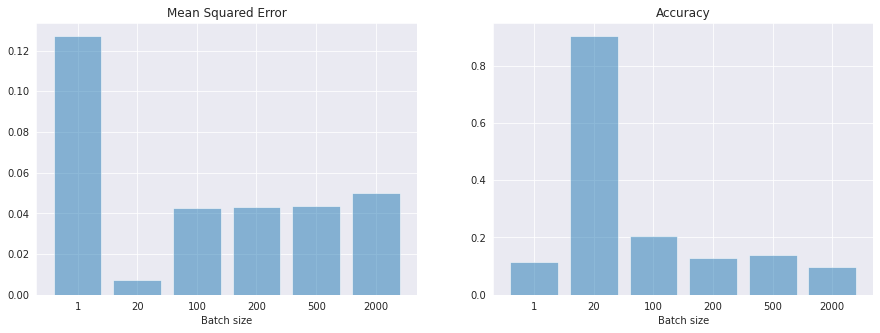

In [ ]:
objects = batch_sizes
performance = test_results_list

# plot performances bars
fig, axes = plt.subplots(1, 2, figsize=(15,5))
y_pos = np.arange(len(objects))
# get mean squared error from performance
model_mse = [x[0] for x in performance]
axes[0].bar(y_pos, model_mse, align='center', alpha=0.5)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Batch size')
axes[0].set_title('Mean Squared Error')

# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes[1].bar(y_pos, model_acc, align='center', alpha=0.5)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Batch size')
axes[1].set_title('Accuracy')
